<a href="https://colab.research.google.com/github/AndrewKrugTech/analyticspractice/blob/main/Dirty%20vs%20Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
! pip install -r requirements.txt

In [40]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import time
import copy
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm

In [2]:
DATA_ROOT = '/home/andrew/analyticspractice/dirtycleaned/'

In [3]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andrewkrug/plates
! unzip plates.zip

100%|█████████████████████████████████████▉| 47.0M/47.1M [00:07<00:00, 6.33MB/s]
100%|██████████████████████████████████████| 47.1M/47.1M [00:07<00:00, 6.43MB/s]
Archive:  plates.zip
  inflating: plates/test/0000.jpg    
  inflating: plates/test/0001.jpg    
  inflating: plates/test/0002.jpg    
  inflating: plates/test/0003.jpg    
  inflating: plates/test/0004.jpg    
  inflating: plates/test/0005.jpg    
  inflating: plates/test/0006.jpg    
  inflating: plates/test/0007.jpg    
  inflating: plates/test/0008.jpg    
  inflating: plates/test/0009.jpg    
  inflating: plates/test/0010.jpg    
  inflating: plates/test/0011.jpg    
  inflating: plates/test/0012.jpg    
  inflating: plates/test/0013.jpg    
  inflating: plates/test/0014.jpg    
  inflating: plates/test/0015.jpg    
  inflating: plates/test/0016.jpg    
  inflating: plates/test/0017.jpg    
  inflating: plates/test/0018.jpg    
  inflating: plates/test/0019.jpg    
  inflating: plates/test/0020.jpg    
  inflating: plates

## Prepare some Classes and Functions for pictures transformations

In [4]:
class RemoveBackground:
    def __init__(self):
        pass

    def __call__(self, in_img):
        in_img = np.array(in_img)
        height, width = in_img.shape[:2]
        mask = np.zeros([height, width], np.uint8)

        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        rect = (15, 15, width-30, height-30)
        cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        out_img = in_img * mask[:, :, np.newaxis]

        background = in_img - out_img

        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        out_img = background + out_img

        return transforms.functional.to_pil_image(out_img)
    

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
def unzip_data(zip_file, destination_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print(f'Files unzipped to \'{destination_dir}\'\n')

def remove_background(image_roots):
    remove_photo_background = RemoveBackground()

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        print(f'{len(files)} pictures was found in {path}', end='')
        for i, file in enumerate(files):
            img_original = cv2.imread(path + file)
            img_cleaned = remove_photo_background(img_original)
            img_cleaned = np.array(img_cleaned)
            cv2.imwrite(path + file, img_cleaned)
            if i % 20 == 0:
                print('\n{:>3d}/{:>3d}'.format(i, len(files)), end='')
            print('.', end='')
        print()
    
def make_extra_images(image_roots):
    prefix_names = ['_090', '_180', '_270']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for i, file in enumerate(files):
            img = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
            for i, angle in enumerate([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]):
                img = cv2.rotate(img, angle)
                img_name = path + file[:file.find('.')] + prefix_names[i] + file[file.find('.'):]
                if not os.path.exists(img_name):
                    cv2.imwrite(img_name, img)

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()
    

def make_train_valid_data():
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        src_dir = os.path.join(data_root, 'train', class_name)
        files = os.listdir(src_dir)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        for i, file_name in enumerate(files):
            if i % 6 != 0:
                dst_dir = os.path.join(train_dir, class_name) 
            else:
                dst_dir = os.path.join(valid_dir, class_name)
            shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))

    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            dst_dir = os.path.join(dir_name, class_name)
            files = os.listdir(dst_dir)
            files = list(filter(lambda x: x.endswith('.jpg'), files))
            print(f'{len(files)} pictures copied to \'{dst_dir}\'')
    print()
    

def make_test_data():
    src_dir = os.path.join(data_root, 'test')
    dst_dir = os.path.join(test_dir, 'unknown')
    print(src_dir, dst_dir)
    shutil.copytree(src_dir, dst_dir)
    files = os.listdir(dst_dir)
    files = list(filter(lambda x: x.endswith('.jpg'), files))
    print(f'{len(files)} pictures copied to \'{dst_dir}\'\n')

# **Unzip data**

## Ok. Let's start :)

In [6]:
# Clear output directory
#!rm * --recursive
shutil.make_archive('plates','zip',DATA_ROOT + '/plates')

'/home/andrew/analyticspractice/dirtycleaned/plates.zip'

In [7]:
    

# Let's define some variables
class_names = ['cleaned', 'dirty']
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Extract images (Kaggle enviropment)
data_root = DATA_ROOT + '/working'

unzip_data(zip_file=DATA_ROOT + '/plates.zip', destination_dir=DATA_ROOT + '/working/')
os.remove(DATA_ROOT + '/plates.zip')


Files unzipped to '/home/andrew/analyticspractice/dirtycleaned//working/'



In [8]:
# Remove images background 
remove_background(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/'),
                               os.path.join(data_root, 'test/')])

# Create extra images for training models
make_extra_images(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])



20 pictures was found in /home/andrew/analyticspractice/dirtycleaned//working/train/cleaned/
  0/ 20....................
20 pictures was found in /home/andrew/analyticspractice/dirtycleaned//working/train/dirty/
  0/ 20....................
744 pictures was found in /home/andrew/analyticspractice/dirtycleaned//working/test/
  0/744....................
 20/744....................
 40/744....................
 60/744....................
 80/744....................
100/744....................
120/744....................
140/744....................
160/744....................
180/744....................
200/744....................
220/744....................
240/744....................
260/744....................
280/744....................
300/744....................
320/744....................
340/744....................
360/744....................
380/744....................
400/744....................
420/744....................
440/744....................
460/744....................
480

In [9]:
def my_same_file_diff_checker(*args, **kwargs):#нереальный костыль
    return False

shutil._samefile = my_same_file_diff_checker

make_train_valid_data()
make_test_data()

66 pictures copied to 'train/cleaned'
66 pictures copied to 'train/dirty'
14 pictures copied to 'valid/cleaned'
14 pictures copied to 'valid/dirty'

/home/andrew/analyticspractice/dirtycleaned//working/test test/unknown
744 pictures copied to 'test/unknown'



## Load data into Datasets
* Create Train, Valid transformation methods (*Test transformations methods will be defined later*)
* Create Train, Valid and Test datasets
* Create Train, Valid and Test dataloaders

In [10]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),}

dataset = {
    'train': torchvision.datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': torchvision.datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test': ImageFolderWithPaths(DATA_ROOT + '/test', transform=None),
}
 
batch_size = 12
train_dataloader = torch.utils.data.DataLoader(dataset['train'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

valid_dataloader = torch.utils.data.DataLoader(dataset['valid'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_dataloader), len(dataset['train'])))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_dataloader), len(dataset['valid'])))
print('{:<7s}{:>10d}{:>10d}'.format('Test',  len(test_dataloader),  len(dataset['test'])))
                            

Dataset   Batches  Pictures
----------------------------
Train          11       132
Valid           3        28
Test          744       744


/home/andrew/.conda/envs/py310/lib/python3.10/site-packages/torchvision/transforms/transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Load some images from batches
It's just for check what we have in datasets

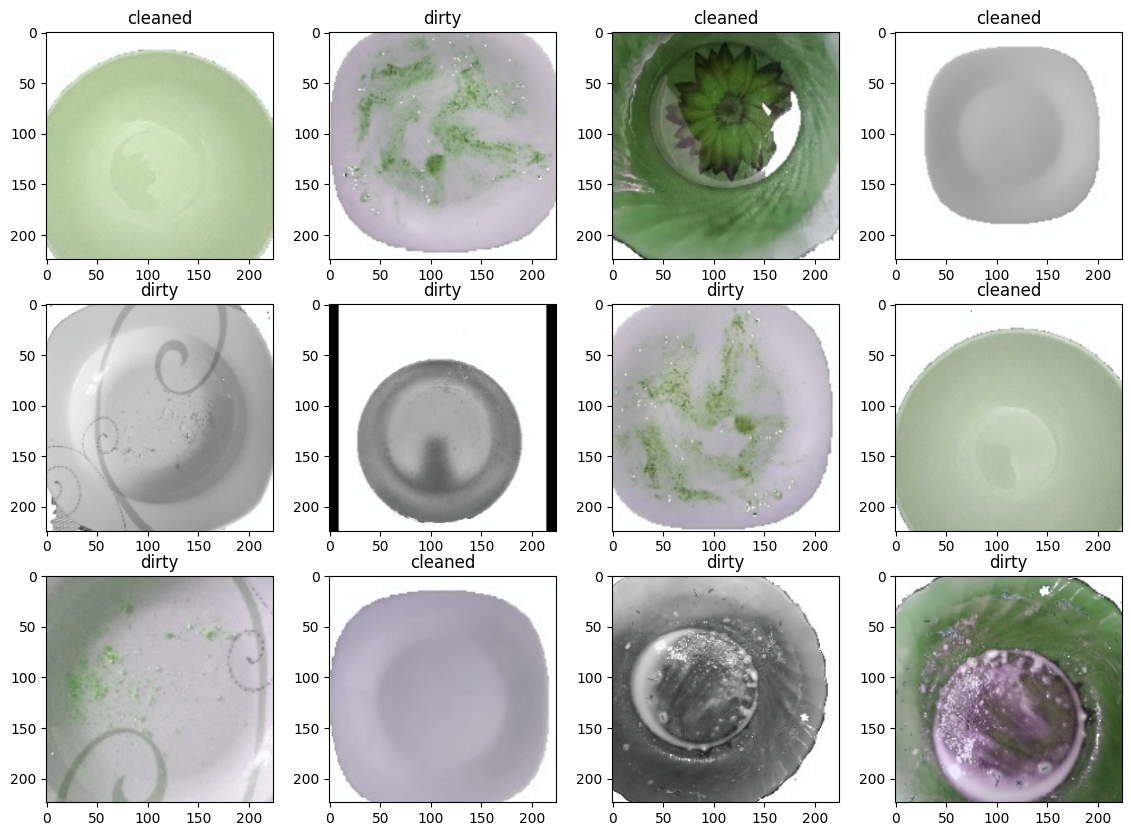

In [11]:

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

image_iter = iter(train_dataloader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(3):
    X_batch, y_batch = next(image_iter)
    for j in range(0, len(X_batch)):
        try:
            plt.subplot(3, 4, i*batch_size + j + 1)
        except ValueError:
            None 
        plt.title(class_names[y_batch[j].item()])
        plt.imshow(((X_batch[j].permute(1, 2, 0).numpy() * std + mean)*255).astype(np.uint8()))

  

# **Create models**

## Several models for training that can be used

In [12]:
class resNet50(torch.nn.Module):
    def __init__(self):
        super(resNet50, self).__init__()
        self.net = models.resnet50(pretrained=True)
        
        for param in self.net.parameters():
            param.requires_grad = False                
        
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

## Model Training Algorithm

In [13]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_hist = {'train':[], 'valid':[]}
    accuracy_hist = {'train':[], 'valid':[]}
    
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                # Running_acc += (preds_class == labels.data).float().mean()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()                


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))

            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)

    return model, loss_hist, accuracy_hist

## Model traning function

In [14]:
def train_MyModel(model, epoch_num):
    print('\n' + model.__class__.__name__ + ' training with {} epochs started...\n'.format(epoch_num))
 
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=epoch_num);
    print('\nModel training finished.')    
    
    return model, losses, accuracies


# **Trainig**

## Run traning
Ok! We are ready for Model Training!
Choose one of them and start

In [15]:
import random
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = resNet50()

model, losses, accuracies = train_MyModel(model, epoch_num=40)

model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/andrew/.conda/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andrew/.conda/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



resNet50 training with 40 epochs started...

       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------


/home/andrew/.conda/envs/py310/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  1/ 40|    0.7312    0.4394|    0.6755    0.5556|
  2/ 40|    0.6566    0.6288|    0.6168    0.6667|
  3/ 40|    0.5700    0.7652|    0.5015    0.9444|
  4/ 40|    0.5106    0.7273|    0.4370    0.7778|
  5/ 40|    0.3711    0.8409|    0.5988    0.6667|
  6/ 40|    0.3492    0.8788|    0.2462    0.9167|
  7/ 40|    0.2667    0.9015|    0.2981    0.9167|
  8/ 40|    0.2750    0.9167|    0.2409    0.8889|
  9/ 40|    0.2509    0.8864|    0.3405    0.8889|
 10/ 40|    0.2328    0.9242|    0.2115    0.9444|
 11/ 40|    0.2550    0.9091|    0.1642    0.9722|
 12/ 40|    0.2357    0.9242|    0.3254    0.8056|
 13/ 40|    0.2748    0.8864|    0.2797    0.9167|
 14/ 40|    0.2192    0.9167|    0.3221    0.8889|
 15/ 40|    0.2048    0.9318|    0.2422    0.8889|
 16/ 40|    0.1881    0.9545|    0.2474    0.9722|
 17/ 40|    0.2209    0.9167|    0.1964    0.9444|
 18/ 40|    0.2618    0.8788|    0.2538    0.9722|
 19/ 40|    0.1987    0.9470|    0.3001    0.7500|
 20/ 40|    0.1922    0.9470|  

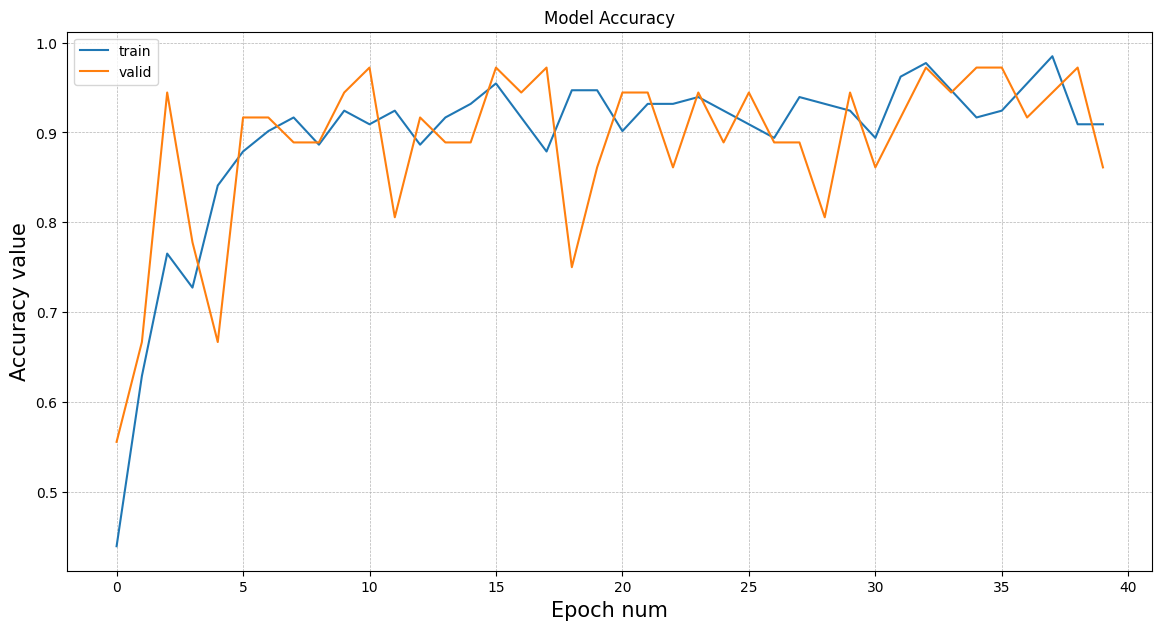

In [16]:

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')


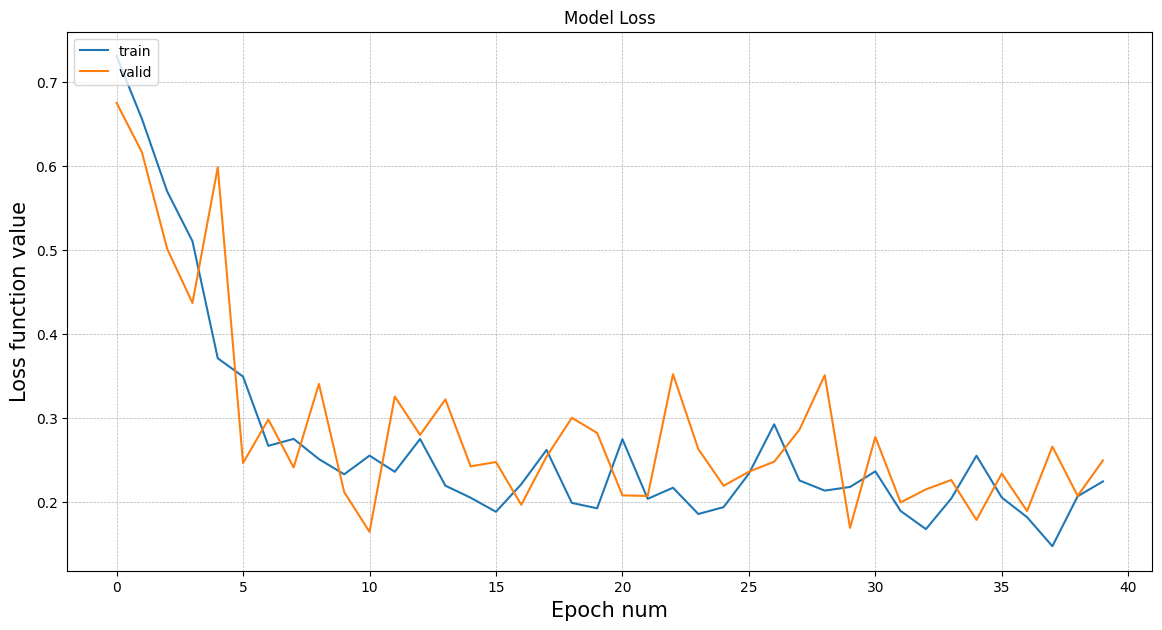

In [17]:

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')


# **Prediction**

## Create a Test transformation methods
Now we are ready for predictions


In [18]:
transform_image = {
    'to_tensor_and_normalize': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# List of transformation methods
transforms_list = { 
    'original': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),   
#     'crop_220': transforms.Compose([
#         transforms.CenterCrop(220),
#         transforms.Resize((224, 224)),
#     ]), 
#     'crop_200': transforms.Compose([
#         transforms.CenterCrop(200),
#         transforms.Resize((224, 224)),
#     ]),    
    'crop_180': transforms.Compose([
        transforms.CenterCrop(180),
        transforms.Resize((224, 224)),
    ]),    
    'crop_160': transforms.Compose([
        transforms.CenterCrop(160),
        transforms.Resize((224, 224)),
    ]),   
    'crop_140': transforms.Compose([
        transforms.CenterCrop(140),
        transforms.Resize((224, 224)),
    ]),   
#     'crop_120': transforms.Compose([
#         transforms.CenterCrop(120),
#         transforms.Resize((224, 224)),
#     ]),    
    'gray_280': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(280),
        transforms.Resize((224, 224)),
    ]),
    'gray_200': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_1': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_2': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_3': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),        
}

# Test Dataset
dataset['test'] = ImageFolderWithPaths(DATA_ROOT + '/test', transform=None)

# Test Dataloaders
test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

## Let's predict the status for one chosen plate

N  Method         Percent
-------------------------
1  original        0.9345
2  crop_180        0.9746
3  crop_160        0.9689
4  crop_140        0.9684
5  gray_280        0.9577
6  gray_200        0.9718
7  r_crop_180_1    0.9724
8  r_crop_180_2    0.9688
9  r_crop_180_3    0.9493
-------------------------


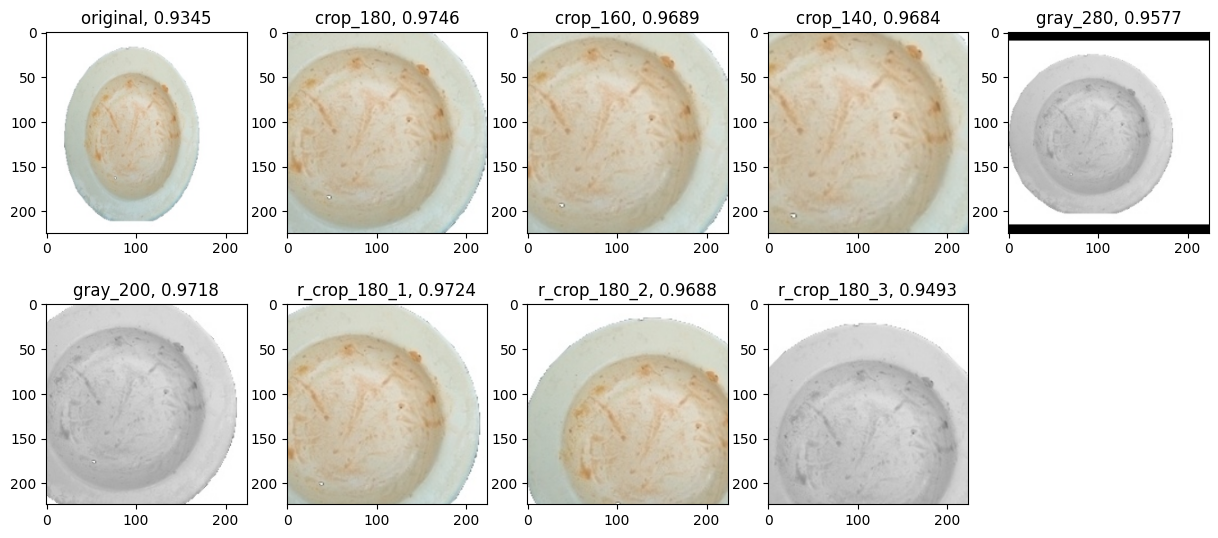

In [39]:
img_id = random.randint(20,60)

img_original = test_dataloader.dataset[img_id][0]

img_id = test_dataloader.dataset[img_id][2]
img_id = img_id.replace(DATA_ROOT + '/working/test/unknown/', '')
img_id = img_id.replace('.jpg', '')

labels = {}
labels['id'] = img_id

for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    tensor = transform_image['to_tensor_and_normalize'](img_transformed)
    tensor = tensor.to(device)
    tensor = tensor.unsqueeze(0)

    with torch.set_grad_enabled(False):
        preds = model(tensor)
        
    label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
    labels[method] = label

plt.rcParams['figure.figsize'] = (15, 10)
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    plt.subplot(3, 5, i + 1)
    plt.title(method + ', ' + str(round(labels[method],4)))
    plt.imshow(img_transformed); 
  
print('{:3s}{:15s}{:7s}'.format('N', 'Method', 'Percent')), print('-' * 25)
for i, method in enumerate([x for x in labels if x != 'id']):
    print('{:<3d}{:<15s}{:>7.4f}'.format(i+1, method, labels[method]))
print('-' * 25)

## Make predictions for all plates

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

data = []
for img_original, labels, img_id in tqdm(test_dataloader.dataset):
    labels = {}
    labels['id'] = img_id
    probs = np.array([])

    for i, method in enumerate(transforms_list):
        img_transformed = transforms_list[method](img_original)
        tensor = transform_image['to_tensor_and_normalize'](img_transformed)
        tensor = tensor.to(device)
        tensor = tensor.unsqueeze(0)

        with torch.set_grad_enabled(False):
            preds = model(tensor)

        label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
        labels[method] = label

    data.append(labels)

100%|██████████| 744/744 [03:26<00:00,  3.60it/s]


# **Submission**

## Data preparation

In [21]:
df = pd.DataFrame(data)

df['id'] = df['id'].str.replace(DATA_ROOT + '/test/unknown/', '')
df['id'] = df['id'].str.replace('.jpg', '')

df.set_index('id', inplace=True)
df.head()

/tmp/ipykernel_54560/2843597473.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['id'] = df['id'].str.replace('.jpg', '')


,original,crop_180,crop_160,crop_140,gray_280,gray_200,r_crop_180_1,r_crop_180_2,r_crop_180_3
id,,,,,,,,,
0000,0.946007,0.969094,0.971771,0.971962,0.962886,0.972063,0.973652,0.950364,0.955362
0001,0.908099,0.938461,0.948936,0.937636,0.843946,0.958659,0.944416,0.936032,0.951319
0002,0.910664,0.166042,0.091345,0.071019,0.625480,0.379535,0.560095,0.260656,0.183162
0003,0.908632,0.975235,0.976867,0.968949,0.970176,0.962705,0.970215,0.973895,0.907287
0004,0.572170,0.960164,0.951379,0.949613,0.947318,0.952156,0.928418,0.941437,0.920757


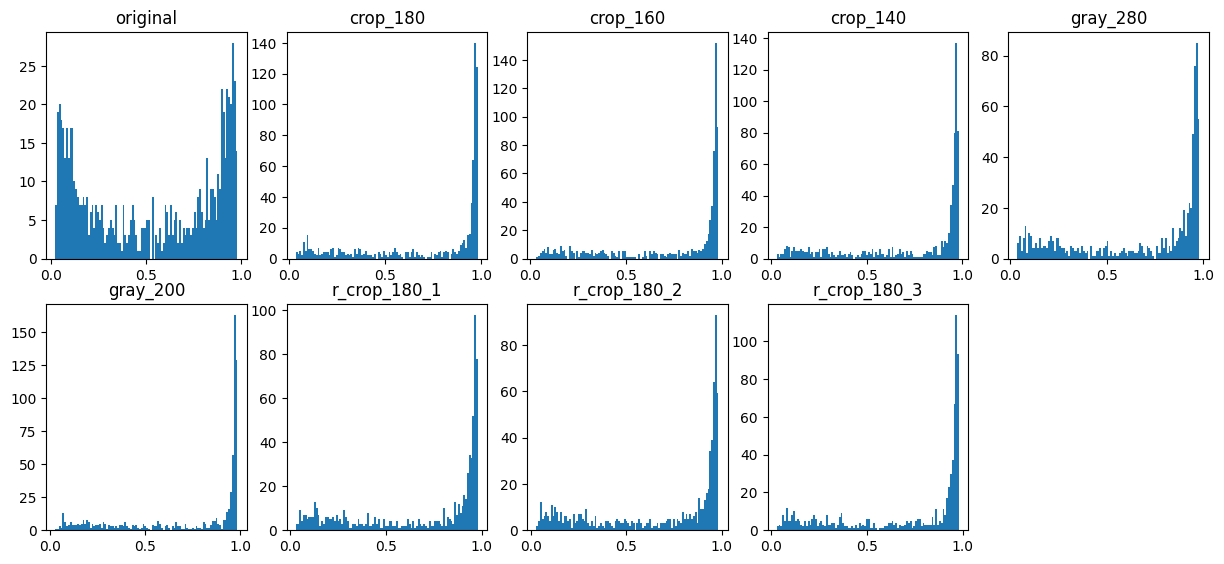

In [22]:
plt.rcParams['figure.figsize'] = (15, 10)
for i, col_name in enumerate(df.columns):
    plt.subplot(3, 5, i + 1)
    plt.title(col_name)
    plt.hist(x=[df[col_name]], bins=100, histtype='bar');


In [23]:
df['original'] = df['original']**(0.6)
# df['crop_220'] = df['crop_220']**(2.0)
# df['crop_200'] = df['crop_200']**(2.0)
df['crop_180'] = df['crop_180']**(2.5)
df['crop_160'] = df['crop_160']**(2.5)
df['crop_140'] = df['crop_140']**(2.5)
# df['crop_120'] = df['crop_120']**(2.0)
df['gray_280'] = df['gray_280']**(2.0)
df['gray_200'] = df['gray_200']**(2.5)
df['r_crop_180_1'] = df['r_crop_180_1']**(2.0)
df['r_crop_180_2'] = df['r_crop_180_2']**(2.0)
df['r_crop_180_3'] = df['r_crop_180_3']**(2.0)

In [24]:
for col_name in df.columns:
    gap = 0.05
    plates_min = 999

    for i in range(40, 70):
        plates_num = df[(df[col_name] > i/100) & (df[col_name] < i/100 + gap)][col_name].count()
        if plates_min > plates_num:
            plates_min = plates_num
            middle = i/100

    df[col_name] = df[col_name] - middle + gap/2

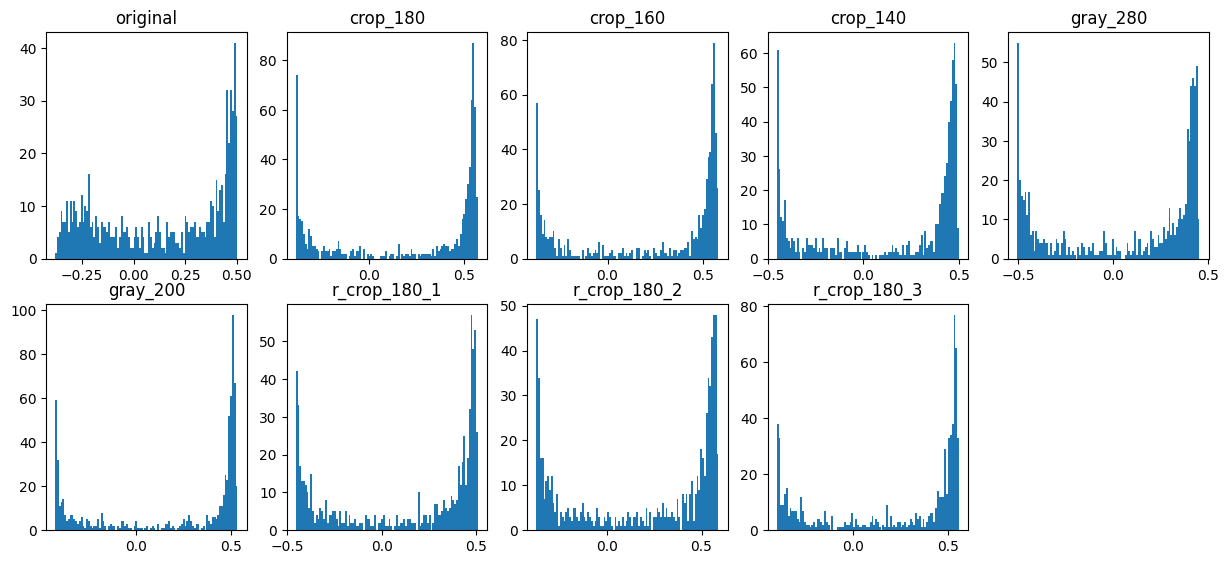

In [25]:
plt.rcParams['figure.figsize'] = (15, 10)
for i, col_name in enumerate(df.columns):
    plt.subplot(3, 5, i + 1)
    plt.title(col_name)
    plt.hist(x=[df[col_name]], bins=100, histtype='bar');

## Export submission file

In [26]:
df['mean'] = df.mean(axis=1) # среднее по всем данным(оригинал + обрезанные версии)
df['label'] = df['mean'].map(lambda x: 'cleaned' if x < 0 else 'dirty')
df.head()

,original,crop_180,crop_160,crop_140,gray_280,gray_200,r_crop_180_1,r_crop_180_2,r_crop_180_3,mean,label
id,,,,,,,,,,,
0000,0.482245,0.539516,0.555915,0.476373,0.422149,0.506613,0.492998,0.528192,0.507716,0.501302,dirty
0001,0.458800,0.468180,0.502187,0.396305,0.207245,0.474829,0.436921,0.501155,0.500007,0.438403,dirty
0002,0.460398,-0.373766,-0.372478,-0.453656,-0.113775,-0.336258,-0.141293,-0.307058,-0.371452,-0.223260,cleaned
0003,0.459132,0.554233,0.568166,0.469171,0.436241,0.484355,0.486318,0.573472,0.418169,0.494362,dirty
0004,0.230344,0.518366,0.507844,0.423753,0.392411,0.459648,0.406960,0.511304,0.442793,0.432602,dirty


In [27]:
#оставили только label
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head()

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty


In [28]:
! rm -rf submission.csv

In [29]:
file_name = model.__class__.__name__ +'_Seed' + str(seed)
df.to_csv('submission.csv')
print("Result: " +  file_name)

Result: resNet50_Seed40


In [30]:
#! rm -rf train valid test plates working plates.zip